## Real-time audio classification to detect scientific hardware malfunction.

**Final Degree Thesis UPF / 2020**

Genís Plaja i Roglans
<br>
_Thesis supervisor:_ Dr. Xavier Serra i Casals
<br>
Dept. of Information and Communication Technologies of Universitat Pompeu Fabra



**Notebook based in:** _Lecture1_IntroWithACaseStudy_ of the MIR course from the MSc in Sound and Music Computing.


## Classification task: Scientific hardware malfunction detection and prevention.

* The principal aim of this project is to design an automatic audio classification methodology to solve real life problems related to scientific hardware malfunction.
* This notebook is based on a specific use case. We are trying to detect when a GC-MS (Gas Chromatography - Mass Spectometry) from DIMOCAT (Universitat de Girona) research group suffers from a technical failure.

In [1]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

In [2]:
#Basic imports
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import numpy as np


## Collecting raw data and investigating its nature

### Creating dataset

In [3]:
#This cell downloads a subset of the UIOWA:MIS dataset
import urllib.request
import zipfile
import os, sys,shutil

**Collect file lists for each case**

In [4]:
main_data_dir = 'audios/'
segments_path = 'audios/segments/'
## If segment exists, delete it ##
if os.path.exists(segments_path):
    shutil.rmtree(segments_path)
    
inst_files = dict()#dictionary containing for each case a list that carries dictionaries
for root, dirs, files in os.walk(main_data_dir):
    for file in files:
        #Let's only keep forte recordings indicated with .wav/.WAV in the file name
        if (file.endswith('.wav') or file.endswith('.WAV')):
            file_name = os.path.join(root,file)
            state = file.split('.')[0]#case name is coded in the filename between the points
            if(len(state) > 0):#avoid MACOS files that start with ._
                files_state = inst_files.get(state)
                if files_state == None:
                    files_state = [file_name]
                else:
                    files_state.append(file_name)
                inst_files[state] = files_state

#Let's print the list of files
inst_files

{'silence': ['audios/silence/silence.iphone.wav',
  'audios/silence/silence.zoom.wav'],
 'working': ['audios/working/working.iphone.wav',
  'audios/working/working.zoom.WAV'],
 'cooling': ['audios/cooling/cooling.zoom.WAV',
  'audios/cooling/cooling.iphone.wav']}

### Investigating and preprocessing raw data

It is often very useful to first check a few samples from the dataset to decide what preprocessing steps are required. Let's have a look at the waveform of one sample recording for each instrument

Sample waveform plots


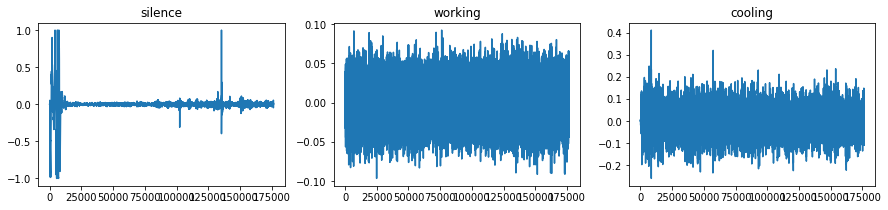

In [5]:
# Raw-data preprocess analysis parameters
fs = 44100

num_states = len(inst_files.keys())
print("Sample waveform plots")
plt.figure(1, figsize=(5 * num_states, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i,state in enumerate(inst_files.keys()):
    sample_file = inst_files[state][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_states,(i+1))
    #We take only the first 44100*4 samples of a single audio of each class, hence 4 seconds.
    plt.plot(x[0:(44100*4)])
    plt.title(state)

We can that the _silence_ class has a very distinguished shape, although we notice some points in the shape that might be outliers, considering the prior knowledge of how the _silence_ class sounds like.

We can also see that the _working_ and _cooling_ plots are quite similar in shape, and that seem to be very noisy sounds. However, the level of the two sounds are different.


### Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

Regarding our dataset, it is made by very long pieces of audio, so the task will be to divide them by a specific window and hop size (to apply some overlapping), apply a window to obtain a smooth contours and avoid outliers.

In [6]:
# Raw-data preprocess analysis parameters
windowSize = 4096 * 4
hopSize = 4096 * 2
# TO DO: ENFINESTRAR
# Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize}

We will create a _segments_ folder, where we will save all the audios slices created.

In [7]:
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir): #creating the directory
    os.mkdir(segments_dir)

segment_files = []
for state, files in inst_files.items():
    file_count = 0
    for sample_file in files:
        print(sample_file)
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
            if (file_count<700):
                if 'zoom' in sample_file:
                    filename = os.path.join(segments_dir, state + '_zoom_' + str(file_count) + '.wav')
                    print(filename)
                    ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(frame)
                    file_count +=1
                    segment_files.append(filename)
                if not 'zoom' in sample_file:
                    filename = os.path.join(segments_dir, state + '_' + str(file_count) + '.wav')
                    print(filename)
                    ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(frame)
                    file_count +=1
                    segment_files.append(filename)
        file_count = 0
        #n = len(x)
        #file_count = 1
        #k = np.arange(0, n, fs)
        #for i in k:
            #audioBlock = x[i*5:min(i + 5*fs - 1, n)]
            #audioBlock_norm = audioBlock / np.max(np.abs(audioBlock))
            #filename = os.path.join(segments_dir, state + '_' + str(file_count) + '.wav')
            #print(filename)
            #ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(audioBlock_norm)
            #file_count +=1
            #segment_files.append(filename)

print(len(segment_files),'segment files created')

audios/silence/silence.iphone.wav
audios/segments/silence_0.wav
audios/segments/silence_1.wav
audios/segments/silence_2.wav
audios/segments/silence_3.wav
audios/segments/silence_4.wav
audios/segments/silence_5.wav
audios/segments/silence_6.wav
audios/segments/silence_7.wav
audios/segments/silence_8.wav
audios/segments/silence_9.wav
audios/segments/silence_10.wav
audios/segments/silence_11.wav
audios/segments/silence_12.wav
audios/segments/silence_13.wav
audios/segments/silence_14.wav
audios/segments/silence_15.wav
audios/segments/silence_16.wav
audios/segments/silence_17.wav
audios/segments/silence_18.wav
audios/segments/silence_19.wav
audios/segments/silence_20.wav
audios/segments/silence_21.wav
audios/segments/silence_22.wav
audios/segments/silence_23.wav
audios/segments/silence_24.wav
audios/segments/silence_25.wav
audios/segments/silence_26.wav
audios/segments/silence_27.wav
audios/segments/silence_28.wav
audios/segments/silence_29.wav
audios/segments/silence_30.wav
audios/segments

audios/segments/silence_331.wav
audios/segments/silence_332.wav
audios/segments/silence_333.wav
audios/segments/silence_334.wav
audios/segments/silence_335.wav
audios/segments/silence_336.wav
audios/segments/silence_337.wav
audios/segments/silence_338.wav
audios/segments/silence_339.wav
audios/segments/silence_340.wav
audios/segments/silence_341.wav
audios/segments/silence_342.wav
audios/segments/silence_343.wav
audios/segments/silence_344.wav
audios/segments/silence_345.wav
audios/segments/silence_346.wav
audios/segments/silence_347.wav
audios/segments/silence_348.wav
audios/segments/silence_349.wav
audios/segments/silence_350.wav
audios/segments/silence_351.wav
audios/segments/silence_352.wav
audios/segments/silence_353.wav
audios/segments/silence_354.wav
audios/segments/silence_355.wav
audios/segments/silence_356.wav
audios/segments/silence_357.wav
audios/segments/silence_358.wav
audios/segments/silence_359.wav
audios/segments/silence_360.wav
audios/segments/silence_361.wav
audios/s

audios/silence/silence.zoom.wav
audios/segments/silence_zoom_0.wav
audios/segments/silence_zoom_1.wav
audios/segments/silence_zoom_2.wav
audios/segments/silence_zoom_3.wav
audios/segments/silence_zoom_4.wav
audios/segments/silence_zoom_5.wav
audios/segments/silence_zoom_6.wav
audios/segments/silence_zoom_7.wav
audios/segments/silence_zoom_8.wav
audios/segments/silence_zoom_9.wav
audios/segments/silence_zoom_10.wav
audios/segments/silence_zoom_11.wav
audios/segments/silence_zoom_12.wav
audios/segments/silence_zoom_13.wav
audios/segments/silence_zoom_14.wav
audios/segments/silence_zoom_15.wav
audios/segments/silence_zoom_16.wav
audios/segments/silence_zoom_17.wav
audios/segments/silence_zoom_18.wav
audios/segments/silence_zoom_19.wav
audios/segments/silence_zoom_20.wav
audios/segments/silence_zoom_21.wav
audios/segments/silence_zoom_22.wav
audios/segments/silence_zoom_23.wav
audios/segments/silence_zoom_24.wav
audios/segments/silence_zoom_25.wav
audios/segments/silence_zoom_26.wav
audios

audios/segments/silence_zoom_348.wav
audios/segments/silence_zoom_349.wav
audios/segments/silence_zoom_350.wav
audios/segments/silence_zoom_351.wav
audios/segments/silence_zoom_352.wav
audios/segments/silence_zoom_353.wav
audios/segments/silence_zoom_354.wav
audios/segments/silence_zoom_355.wav
audios/segments/silence_zoom_356.wav
audios/segments/silence_zoom_357.wav
audios/segments/silence_zoom_358.wav
audios/segments/silence_zoom_359.wav
audios/segments/silence_zoom_360.wav
audios/segments/silence_zoom_361.wav
audios/segments/silence_zoom_362.wav
audios/segments/silence_zoom_363.wav
audios/segments/silence_zoom_364.wav
audios/segments/silence_zoom_365.wav
audios/segments/silence_zoom_366.wav
audios/segments/silence_zoom_367.wav
audios/segments/silence_zoom_368.wav
audios/segments/silence_zoom_369.wav
audios/segments/silence_zoom_370.wav
audios/segments/silence_zoom_371.wav
audios/segments/silence_zoom_372.wav
audios/segments/silence_zoom_373.wav
audios/segments/silence_zoom_374.wav
a

audios/working/working.iphone.wav
audios/segments/working_0.wav
audios/segments/working_1.wav
audios/segments/working_2.wav
audios/segments/working_3.wav
audios/segments/working_4.wav
audios/segments/working_5.wav
audios/segments/working_6.wav
audios/segments/working_7.wav
audios/segments/working_8.wav
audios/segments/working_9.wav
audios/segments/working_10.wav
audios/segments/working_11.wav
audios/segments/working_12.wav
audios/segments/working_13.wav
audios/segments/working_14.wav
audios/segments/working_15.wav
audios/segments/working_16.wav
audios/segments/working_17.wav
audios/segments/working_18.wav
audios/segments/working_19.wav
audios/segments/working_20.wav
audios/segments/working_21.wav
audios/segments/working_22.wav
audios/segments/working_23.wav
audios/segments/working_24.wav
audios/segments/working_25.wav
audios/segments/working_26.wav
audios/segments/working_27.wav
audios/segments/working_28.wav
audios/segments/working_29.wav
audios/segments/working_30.wav
audios/segments

audios/segments/working_352.wav
audios/segments/working_353.wav
audios/segments/working_354.wav
audios/segments/working_355.wav
audios/segments/working_356.wav
audios/segments/working_357.wav
audios/segments/working_358.wav
audios/segments/working_359.wav
audios/segments/working_360.wav
audios/segments/working_361.wav
audios/segments/working_362.wav
audios/segments/working_363.wav
audios/segments/working_364.wav
audios/segments/working_365.wav
audios/segments/working_366.wav
audios/segments/working_367.wav
audios/segments/working_368.wav
audios/segments/working_369.wav
audios/segments/working_370.wav
audios/segments/working_371.wav
audios/segments/working_372.wav
audios/segments/working_373.wav
audios/segments/working_374.wav
audios/segments/working_375.wav
audios/segments/working_376.wav
audios/segments/working_377.wav
audios/segments/working_378.wav
audios/segments/working_379.wav
audios/segments/working_380.wav
audios/segments/working_381.wav
audios/segments/working_382.wav
audios/s

audios/working/working.zoom.WAV
audios/segments/working_zoom_0.wav
audios/segments/working_zoom_1.wav
audios/segments/working_zoom_2.wav
audios/segments/working_zoom_3.wav
audios/segments/working_zoom_4.wav
audios/segments/working_zoom_5.wav
audios/segments/working_zoom_6.wav
audios/segments/working_zoom_7.wav
audios/segments/working_zoom_8.wav
audios/segments/working_zoom_9.wav
audios/segments/working_zoom_10.wav
audios/segments/working_zoom_11.wav
audios/segments/working_zoom_12.wav
audios/segments/working_zoom_13.wav
audios/segments/working_zoom_14.wav
audios/segments/working_zoom_15.wav
audios/segments/working_zoom_16.wav
audios/segments/working_zoom_17.wav
audios/segments/working_zoom_18.wav
audios/segments/working_zoom_19.wav
audios/segments/working_zoom_20.wav
audios/segments/working_zoom_21.wav
audios/segments/working_zoom_22.wav
audios/segments/working_zoom_23.wav
audios/segments/working_zoom_24.wav
audios/segments/working_zoom_25.wav
audios/segments/working_zoom_26.wav
audios

audios/segments/working_zoom_240.wav
audios/segments/working_zoom_241.wav
audios/segments/working_zoom_242.wav
audios/segments/working_zoom_243.wav
audios/segments/working_zoom_244.wav
audios/segments/working_zoom_245.wav
audios/segments/working_zoom_246.wav
audios/segments/working_zoom_247.wav
audios/segments/working_zoom_248.wav
audios/segments/working_zoom_249.wav
audios/segments/working_zoom_250.wav
audios/segments/working_zoom_251.wav
audios/segments/working_zoom_252.wav
audios/segments/working_zoom_253.wav
audios/segments/working_zoom_254.wav
audios/segments/working_zoom_255.wav
audios/segments/working_zoom_256.wav
audios/segments/working_zoom_257.wav
audios/segments/working_zoom_258.wav
audios/segments/working_zoom_259.wav
audios/segments/working_zoom_260.wav
audios/segments/working_zoom_261.wav
audios/segments/working_zoom_262.wav
audios/segments/working_zoom_263.wav
audios/segments/working_zoom_264.wav
audios/segments/working_zoom_265.wav
audios/segments/working_zoom_266.wav
a

audios/segments/working_zoom_500.wav
audios/segments/working_zoom_501.wav
audios/segments/working_zoom_502.wav
audios/segments/working_zoom_503.wav
audios/segments/working_zoom_504.wav
audios/segments/working_zoom_505.wav
audios/segments/working_zoom_506.wav
audios/segments/working_zoom_507.wav
audios/segments/working_zoom_508.wav
audios/segments/working_zoom_509.wav
audios/segments/working_zoom_510.wav
audios/segments/working_zoom_511.wav
audios/segments/working_zoom_512.wav
audios/segments/working_zoom_513.wav
audios/segments/working_zoom_514.wav
audios/segments/working_zoom_515.wav
audios/segments/working_zoom_516.wav
audios/segments/working_zoom_517.wav
audios/segments/working_zoom_518.wav
audios/segments/working_zoom_519.wav
audios/segments/working_zoom_520.wav
audios/segments/working_zoom_521.wav
audios/segments/working_zoom_522.wav
audios/segments/working_zoom_523.wav
audios/segments/working_zoom_524.wav
audios/segments/working_zoom_525.wav
audios/segments/working_zoom_526.wav
a

audios/segments/cooling_zoom_212.wav
audios/segments/cooling_zoom_213.wav
audios/segments/cooling_zoom_214.wav
audios/segments/cooling_zoom_215.wav
audios/segments/cooling_zoom_216.wav
audios/segments/cooling_zoom_217.wav
audios/segments/cooling_zoom_218.wav
audios/segments/cooling_zoom_219.wav
audios/segments/cooling_zoom_220.wav
audios/segments/cooling_zoom_221.wav
audios/segments/cooling_zoom_222.wav
audios/segments/cooling_zoom_223.wav
audios/segments/cooling_zoom_224.wav
audios/segments/cooling_zoom_225.wav
audios/segments/cooling_zoom_226.wav
audios/segments/cooling_zoom_227.wav
audios/segments/cooling_zoom_228.wav
audios/segments/cooling_zoom_229.wav
audios/segments/cooling_zoom_230.wav
audios/segments/cooling_zoom_231.wav
audios/segments/cooling_zoom_232.wav
audios/segments/cooling_zoom_233.wav
audios/segments/cooling_zoom_234.wav
audios/segments/cooling_zoom_235.wav
audios/segments/cooling_zoom_236.wav
audios/segments/cooling_zoom_237.wav
audios/segments/cooling_zoom_238.wav
a

audios/segments/cooling_290.wav
audios/segments/cooling_291.wav
audios/segments/cooling_292.wav
audios/segments/cooling_293.wav
audios/segments/cooling_294.wav
audios/segments/cooling_295.wav
audios/segments/cooling_296.wav
audios/segments/cooling_297.wav
audios/segments/cooling_298.wav
audios/segments/cooling_299.wav
audios/segments/cooling_300.wav
audios/segments/cooling_301.wav
audios/segments/cooling_302.wav
audios/segments/cooling_303.wav
audios/segments/cooling_304.wav
audios/segments/cooling_305.wav
audios/segments/cooling_306.wav
audios/segments/cooling_307.wav
audios/segments/cooling_308.wav
audios/segments/cooling_309.wav
audios/segments/cooling_310.wav
audios/segments/cooling_311.wav
audios/segments/cooling_312.wav
audios/segments/cooling_313.wav
audios/segments/cooling_314.wav
audios/segments/cooling_315.wav
audios/segments/cooling_316.wav
audios/segments/cooling_317.wav
audios/segments/cooling_318.wav
audios/segments/cooling_319.wav
audios/segments/cooling_320.wav
audios/s

audios/segments/cooling_559.wav
audios/segments/cooling_560.wav
audios/segments/cooling_561.wav
audios/segments/cooling_562.wav
audios/segments/cooling_563.wav
audios/segments/cooling_564.wav
audios/segments/cooling_565.wav
audios/segments/cooling_566.wav
audios/segments/cooling_567.wav
audios/segments/cooling_568.wav
audios/segments/cooling_569.wav
audios/segments/cooling_570.wav
audios/segments/cooling_571.wav
audios/segments/cooling_572.wav
audios/segments/cooling_573.wav
audios/segments/cooling_574.wav
audios/segments/cooling_575.wav
audios/segments/cooling_576.wav
audios/segments/cooling_577.wav
audios/segments/cooling_578.wav
audios/segments/cooling_579.wav
audios/segments/cooling_580.wav
audios/segments/cooling_581.wav
audios/segments/cooling_582.wav
audios/segments/cooling_583.wav
audios/segments/cooling_584.wav
audios/segments/cooling_585.wav
audios/segments/cooling_586.wav
audios/segments/cooling_587.wav
audios/segments/cooling_588.wav
audios/segments/cooling_589.wav
audios/s

In [8]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)

Segments saved into separate files. Check the "audios/segments/" folder.

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [FreesoundExtractor function of Essentia](https://essentia.upf.edu/freesound_extractor.html#configuration) which is a feature extractor for sound analysis which suits perfeclty in our line of research.

Let's first run it for a file and check its output:

In [9]:
import essentia.standard as es

#Running music extractor for a file:
file = segment_files[0]#simply pick the first file in the list
features, features_frames = es.FreesoundExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)
features_validation, features_frames_validation = es.FreesoundExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)

Essentia-MusicExtractor extracts a large number of features. As we want our model to work in real-time, our goal will be to obtain a the best classification accuracy that we can, using the less descriptors the better, as the computation will be less demanding.

In [10]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if ('lowlevel.spectral_centroid.mean' in descriptor) or ('lowlevel.spectral_spread.mean' in descriptor) and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)
num_of_descriptors = len(scalar_lowlevel_descriptors)
print(num_of_descriptors)#Number of chosen descriptors

Subset of features to be considered:
 ['lowlevel.spectral_centroid.mean', 'lowlevel.spectral_spread.mean']
2


Running FreesoundExtractor for all files, keeping the selected subset of features, writing to an output file: data.csv

In this case, we will create a data csv file for both the train and validation sets just to make sure that we can choose which information goes to each of the two. We apply an _if_ condition to put in each file the features of the samples that we need in each of the specific experiments.

In [12]:
# Extracting features and writing in data_file.csv file in the segments folder
# Each line in the data_file.csv file represents a sample with features and the class information as the last element
data_file_train = os.path.join(segments_dir,'data_train.csv')
data_file_validation = os.path.join(segments_dir,'data_validation.csv')
file_count = 0
with open(data_file_train, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['state']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in segment_files:
        if '.wav' and not 'zoom' in file:
            file_count +=1
            if file_count % 20 == 0:#print name of a file every 20 files
                print(file_count, "files processed, current file: ",file)
            features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            state = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + state + '\n'
            writer.write(line2write)
with open(data_file_validation, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['state']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in segment_files:
        if '.wav' and 'zoom' in file:
            file_count +=1
            if file_count % 20 == 0:#print name of a file every 20 files
                print(file_count, "files processed, current file: ",file)
            features_validation, features_frames_validation = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features_validation = [features_validation[descriptor] for descriptor in scalar_lowlevel_descriptors]
            state = file.split('/')[-1].split('_')[0].lower() #class information
            line2write = str(selected_features_validation)[1:-1] + ',' + state + '\n'
            writer.write(line2write)
            
print("A total of ",file_count, "files processed")
print(selected_features)

20 files processed, current file:  audios/segments/silence_19.wav
40 files processed, current file:  audios/segments/silence_39.wav
60 files processed, current file:  audios/segments/silence_59.wav
80 files processed, current file:  audios/segments/silence_79.wav
100 files processed, current file:  audios/segments/silence_99.wav
120 files processed, current file:  audios/segments/silence_119.wav
140 files processed, current file:  audios/segments/silence_139.wav
160 files processed, current file:  audios/segments/silence_159.wav
180 files processed, current file:  audios/segments/silence_179.wav
200 files processed, current file:  audios/segments/silence_199.wav
220 files processed, current file:  audios/segments/silence_219.wav
240 files processed, current file:  audios/segments/silence_239.wav
260 files processed, current file:  audios/segments/silence_259.wav
280 files processed, current file:  audios/segments/silence_279.wav
300 files processed, current file:  audios/segments/silen

2400 files processed, current file:  audios/segments/silence_zoom_299.wav
2420 files processed, current file:  audios/segments/silence_zoom_319.wav
2440 files processed, current file:  audios/segments/silence_zoom_339.wav
2460 files processed, current file:  audios/segments/silence_zoom_359.wav
2480 files processed, current file:  audios/segments/silence_zoom_379.wav
2500 files processed, current file:  audios/segments/silence_zoom_399.wav
2520 files processed, current file:  audios/segments/silence_zoom_419.wav
2540 files processed, current file:  audios/segments/silence_zoom_439.wav
2560 files processed, current file:  audios/segments/silence_zoom_459.wav
2580 files processed, current file:  audios/segments/silence_zoom_479.wav
2600 files processed, current file:  audios/segments/silence_zoom_499.wav
2620 files processed, current file:  audios/segments/silence_zoom_519.wav
2640 files processed, current file:  audios/segments/silence_zoom_539.wav
2660 files processed, current file:  a

## Analysis and preprocessing of features

All extracted features are saved in data.csv. Columns represent features and rows files/samples. This is a typical format in a large number of machine learning datasets (see a few of the dataset here: https://archive.ics.uci.edu/ml/index.php or other "Data Science" examples on the web).  

***The use of a common format for data representation is beneficial in both making use of existing tools/libraries (such as Pandas) and contributing to the community with resources that are easy to use.***

Let's load the data and start investigating the features. We can use Pandas (a package largely used in data science) to read data and access statistical description of the features. 

Remember that we created two data files, so we must read both of them separatedly.

In [13]:
import pandas as pd

In [14]:
#Read data
data_train = pd.read_csv(data_file_train)
data_validation = pd.read_csv(data_file_validation)
#Let's see the first lines of our data
data_train.head()

,spectral_centroid.mean,spectral_spread.mean,state
0,550.587585,5950551.5,silence
1,869.436035,8215683.0,silence
2,1041.962402,8563184.0,silence
3,1107.188232,8802325.0,silence
4,1632.097168,10751251.0,silence


All features are represented with columns, and the column ('state') carries the class information.

Always check if your data involves NaN values and clean them (by simply removing the sample, or replacing the NaN value by a real value (such as the median of that feature)).

In [15]:
#sums a matrix of True/False values obtained by checking if each value is Nan
data_train.isnull().sum().sum()
data_validation.isnull().sum().sum()

0

**Observation:** No NaN value, proceed ..

We can plot samples on two-dimensional feature spaces to check if features are discriminative for those classes. Here is an example:

In [ ]:
import seaborn as sns
sns.relplot(x = "spectral_centroid.mean", y = "spectral_spread.mean", hue = "state", style = "state", data = data_train);

The Seaborn package includes some very useful plotting functions that facilitate such visual inspections. Here is another example: this time producing plots **for the last 6 features**, creating all combinations to form 2-dimensional feature spaces representing the samples from different classes

In [ ]:
sns.pairplot(data_train.iloc[:, -4:], hue = "state");

As the next step, having a look at descriptive statistics of the features would be useful. Let's do that:

In [ ]:
#Descriptive statistics of the features:
data_train.describe()

**Observation:** min, max, mean values of the features vary a lot, we need to normalise them. Some of the features (such as average loudness) may be irrelevant for the task (check variance of the features). For simplicity of the code here, we will keep all the features as is, but you should consider removing irrelevant features from the list.

### Preprocessing of the features

**Normalisation of the features**

In [ ]:
data_train_modif = data_train.copy()
data_validation_modif = data_validation.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler_train = preprocessing.MinMaxScaler()
min_max_scaler_validation = preprocessing.MinMaxScaler()
data_train_modif.iloc[:,:num_of_descriptors] = min_max_scaler_train.fit_transform(data_train.iloc[:,:num_of_descriptors].values)
data_validation_modif.iloc[:,:num_of_descriptors] = min_max_scaler_validation.fit_transform(data_validation.iloc[:,:num_of_descriptors].values)

In [ ]:
data_train_modif.describe()

**Observation:** Now the features are normalised in [0,1] range, proceed to converting data into matrices that can be fed into classifiers.

We should check if our data is balanced (if there are the same number of samples for each class).

Let's start with the train set:

In [ ]:
samples_per_class_train = data_train_modif.state.value_counts().to_numpy()
data_train_modif.state.value_counts()

And now the validation set:

In [ ]:
samples_per_class_validation = data_validation_modif.state.value_counts().to_numpy()
data_validation_modif.state.value_counts()

**Observation:** WE MUST BALANCE THE DATA IF IT IS NOT.

### Balancing the data
If the data needs to be balanced, we will discard samples from the classes that have more samples to force the number of samples for each class to match. If every class have the same amount of samples, this cell does not produce any changes.

In [ ]:
min_number_train = min(samples_per_class_train) #Take minimum value of samples per class to balance the data
cooling_train_data = data_train_modif[data_train_modif.state == 'cooling'].sample(n = min_number_train, random_state = 42)
silence_train_data = data_train_modif[data_train_modif.state == 'silence'].sample(n = min_number_train, random_state = 42)
working_train_data = data_train_modif[data_train_modif.state == 'working'].sample(n = min_number_train, random_state = 42)
#Merging after downsampling
data_train_modif = pd.concat([cooling_train_data, silence_train_data, working_train_data])
#Checking the balance again
data_train_modif.state.value_counts()

In [ ]:
min_number_validation = min(samples_per_class_validation) #Take min value of samples per class to balance the data
cooling_validation_data = data_validation_modif[data_validation_modif.state == 'cooling'].sample(n = min_number_validation, random_state = 42)
silence_validation_data = data_validation_modif[data_validation_modif.state == 'silence'].sample(n = min_number_validation, random_state = 42)
working_validation_data = data_validation_modif[data_validation_modif.state == 'working'].sample(n = min_number_validation, random_state = 42)
#Merging after downsampling
data_test_modif = pd.concat([cooling_validation_data, silence_validation_data, working_validation_data])
#Checking the balance again
data_validation_modif.state.value_counts()

## Training an automatic classifier and testing it

**Preparing data arrays for features (inputs, X) and labels (outputs, y):**

Now, we can form the input-output matrices that can be fed into classifiers. You can refer to [the tutorials of the scikit learn package](https://scikit-learn.org/stable/tutorial/index.html) to get familiar with the input-output formats.

In [ ]:
X_train = data_train_modif.iloc[:,:num_of_descriptors].values
X_validation = data_validation_modif.iloc[:,:num_of_descriptors].values 

# Creating output values
data_train_modif.state = pd.Categorical(data_train_modif.state) #convert train to categorical data
data_validation_modif.state = pd.Categorical(data_validation_modif.state) #convert validation to categorical data
y_train = np.array(data_train_modif.state.cat.codes) #create label encoded outputs
y_validation = np.array(data_validation_modif.state.cat.codes) #create label encoded outputs

#Print the first sample of train and validation
print("Features of the first train sample: ", X_train[0])
print("Features of the first validation sample: ", X_validation[0])
print("Class of the first train sample: ", y_train[0])
print("Class of the first validation sample: ", y_validation[0])

Let's check content of the outputs vector 

In [ ]:
#All output values: ebclar: 0, flute: 1, vibraphone: 2, violin: 3
print(y_train)

In [ ]:
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_validation.shape, ", Size of test output vector: ",y_validation.shape)

**Defining the machine learning model and training it**

Now we can train a machine learning model. Let's pick a Support Vector Machine (SVM) model and feed our data to train it.

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))
clf.fit(X_train, y_train)                         

**validating the model**

The model is trained. Now, one can perform prediction using the model for a given set of features. If we feed the features of the validation set, we expect to find the classes of the validation set (true values of it are stored in y_validation). We will refer to the output as "predicted classes (y_pred)."

Then we will use the results obtained to modify the model settings in order to achieve the better accuracy with the less computational cost as possible.

In [ ]:
y_pred = clf.predict(X_validation)

In [ ]:
#Let's check for each sample in the validation set if prediction matches the true class information
y_validation == y_pred

In [ ]:
# Data is balanced, so you can use accuracy as a measure:
print("Accuracy: ", np.sum(y_validation == y_pred)/len(y_validation))

We want the accuracy to be over 0.99 (as we are talking about a real life market product!) and if it does not work with a substantial guarantee it cannot be considered a useful product...

As the final step, let's also print the **confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_train_modif.state)
conf_mat = pd.DataFrame(confusion_matrix(y_validation, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

### TO DO: ONCE THE MODEL IS DEFINED, IMPORT THE TEST SET AND TEST THE OVERALL ACCURACY OF OUR MODEL.

**Stand-alone use of a trained model:** 

Now that we have a trained model, we have the tools to perform automatic instrument classification of isolated notes. Below, you find the code to run classification on audio files. This cell does not aim testing (because it also includes the training samples) but just a demonstration of the predictions of our model.

In [ ]:
#Class names dictionary
classes = { 0: 'cooling', 1: 'silence', 2: 'working'}

#Here is the standalone function to run prediction for a given audio file
def predict_state(file, selected_feature_names, normalizer, classes, classifier):
    '''Predicts the instrument class for the given audio file
    '''
    #Extract features for a given file
    features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(file)
    #Pick the features we have used in our model
    selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
    #Applying learned scaling to the features
    scaled_features = min_max_scaler.transform(np.array(selected_features).reshape(1, -1))

    #Running prediction
    y_pred = classifier.predict(scaled_features)
    #Return predicted class 
    return classes[y_pred[0]]
#--------------------------------------------------------------------
#Running prediction on individual files
for file in segment_files:
    state_pred = predict_state(file, scalar_lowlevel_descriptors, min_max_scaler, classes, clf)

    #Printing the output
    print(file, " predicted as ", state_pred)

#!!! This is not a test (as it also contains training samples) but a simple demonstration 
# running standalone classifier on all files

### Comparing classifiers

Above, we have carried tests for one type of classifier. It is a common practice to compare performances of various classifiers with various settings. Below, we provide an example of such comparison on a limited set of classifiers. 

In [ ]:
#Edited version of https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
import warnings
warnings.filterwarnings('ignore')#suppress warnings
#importing various classifiers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma = 1 / (X_train.shape[-1] * X_train.var())),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB()]

names = ["KNN", "Linear SVM", "RBF SVM", "Gaussian Process","Neural Net", "Naive Bayes"]

#Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []

#Let's split our data into test and train
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 1)

#Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_train, x_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 1/num_tests, random_state = iteration_number)
    #normalisation of the data (learned from training data, applied to test data)
    scaler = StandardScaler().fit(x_train)
    norm_x_train = scaler.transform(x_train)
    norm_x_val = scaler.transform(x_val)
    
    # test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_train, y_train)#train
        score = clf.score(norm_x_val, y_val)#test
        scores[name].append(score)

for name, score in scores.items():
    print("{0}: acc = {1:1.2f}, +-{2:1.2f},\tvalues: {3}".format(name, np.mean(score), np.std(score), np.around(score, decimals = 2)))


Following this comparison, you can pick the classifier with highest performance, and report its performance on the test set

In [ ]:
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)
selected_model = SVC(kernel="linear", C=0.025)#Linear SVM performance is high, let's pick that one
selected_model.fit(norm_x_train_val,y_train_val)
y_pred = selected_model.predict(norm_x_test)
print("Number of test samples: ", len(y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

<img src=https://miro.medium.com/max/974/1*CNWo23_VnUJPXdfrqbiB0g.jpeg width="400">

<img src=https://www.oreilly.com/library/view/python-data-analysis/9781785282287/graphics/B04223_10_02.jpg width="250">

### How about Deep Learning?

We would often prefer deep learning based architectures when the data size is large. See Andrew Ng's figure from his [Coursera course](https://www.coursera.org/learn/neural-networks-deep-learning/):

<img src=https://raw.githubusercontent.com/mbadry1/DeepLearning.ai-Summary/master/1-%20Neural%20Networks%20and%20Deep%20Learning/Images/11.png width="700">

The data size in our case is small and the methods examplified above are just fine. Below, for the sake of presenting an example using a deep learning architecture, we build (with Keras) and train a DNN using the same features. For cases with larger data sets, feature extraction step can be dropped and end-to-end systems(audio->label) can be designed. Due to the size of our data, we will stick with our features.


In [ ]:
#Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)
#..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

Our neural network will have 4 neurons at the output layer each of which will output the estimated probability of the sample belonging to a class. So, let's convert our labels to **one-hot encoding** to fit to that representation.
Example: a sample belonging to the 'violin' class is represented with 3 (integer encoded) will be represented with  [0 0 0 1]. Similarly, a 'ebclar' sample represented with with 0 will be represented with [1 0 0 0]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

**Let's define our deep learning architecture**

In [ ]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 4))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

You can have a look at the summary of the model

In [ ]:
model.summary()

Let's pick an optimizer, compile the model and train the network

In [ ]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0,)

Testing the trained model

In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

It is a good and common practice to check the learning curves

In [ ]:
# summarize history for accuracy
plt.plot(summary.history['acc'])
plt.plot(summary.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()